In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from datetime import date
from datetime import timedelta

In [5]:
from sqlalchemy import extract
from sqlalchemy import desc

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)

measurement_col = []

columns = inspector.get_columns('measurement')
for c in columns:
    measurement_col.append(c['name'])
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
measurement_col

['id', 'station', 'date', 'prcp', 'tobs']

In [14]:
station_col = []
columns = inspector.get_columns('station')
for c in columns:
    station_col.append(c['name'])
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
station_col

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Climate Analysis

1 Design a query to retrieve the last 12 months of precipitation data and plot the results

2 Calculate the date 1 year ago from the last data point in the database

3 Perform a query to retrieve the data and precipitation scores

4 Save the query results as a Pandas DataFrame and set the index to the date column

5 Sort the dataframe by date

6 Use Pandas Plotting with Matplotlib to plot the data


In [16]:
last_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

result = [str(datestr) for datestr in last_date]

last_date_split = result[0].split('-')

last_date_split

['2017', '08', '23']

In [17]:
last_date

('2017-08-23')

In [18]:
last_12_month_date = dt.date(int(last_date_split[0]),int(last_date_split[1]),int(last_date_split[2])) - dt.timedelta(365)

last_12_month_date

datetime.date(2016, 8, 23)

In [19]:
#Query
prcp_last_12 = session.query(Measurement.date,Measurement.prcp).\
                filter(func.datetime(Measurement.date) >= last_12_month_date).\
                order_by(Measurement.date).all()         




In [20]:
prcp_pd = pd.DataFrame(prcp_last_12)
prcp_pd= prcp_pd.dropna()

In [21]:
prcp_pd.set_index('date',inplace=True)

In [22]:
prcp_pd.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


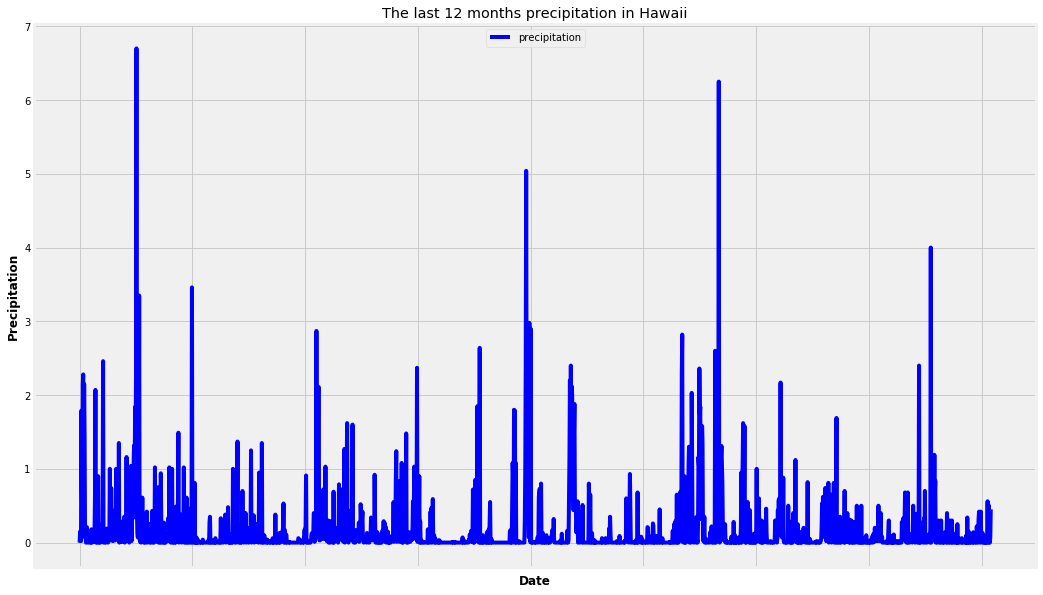

In [23]:

prcp_pd.plot(figsize = (16, 10), sort_columns=True,use_index=True, legend=True,grid=True, color='b')

plt.ylabel('Precipitation', weight='bold')
plt.xlabel('Date', weight='bold')
label_t = plt.legend(loc='upper center')
label_t.get_texts()[0].set_text('precipitation')
plt.title("The last 12 months precipitation in Hawaii")
plt.show()

In [24]:
### Use Pandas to calcualte the summary statistics for the precipitation data

In [25]:
prcp_pd.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?

station_count_query = session.query(func.count(Station.station)).scalar()


In [27]:
print('Totle Station Number:',station_count_query)

Totle Station Number: 9


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activities_query = session.query(Measurement.station,func.count('Measurement.date')).\
                                            group_by('Measurement.station').\
                                            order_by(desc(func.count('Measurement.date'))).all()





/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'Measurement.station'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


### List the stations and observation counts in descending order.

In [29]:
station_activities_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Which station has the highest number of observations?

In [30]:

print('the highest number of observations STATION is ',station_activities_query[0][0])

the highest number of observations STATION is  USC00519281


## Design a query to retrieve the last 12 months of temperature observation data (tobs).
### Choose the station which has the highest number of observations to query

In [31]:
tob_last_12 = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
                filter(func.datetime(Measurement.date) > last_12_month_date).\
                filter(Measurement.station==station_activities_query[0][0]).\
                order_by(Measurement.date).all()   

In [32]:
tob_last_12_pd = pd.DataFrame(tob_last_12)

tob_last_12_pd.dropna()
tob_last_12_pd.count()

station    352
date       352
tobs       352
dtype: int64

In [33]:
tob_last_12_pd.head()

,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0


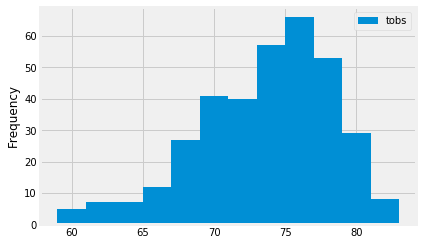

In [34]:
tob_last_12_pd.plot(kind='hist',bins=12)

# Temperature Analysis (Optional)


In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Trip Date '2017-12-28', '2017-01-15'

trip_temp = calc_temps('2016-12-28', '2017-01-15')
trip_temp[0]

(60.0, 69.0, 81.0)

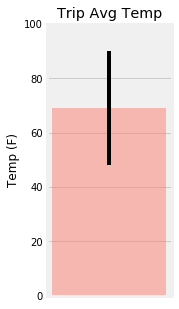

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr_t= trip_temp[0][2] - trip_temp[0][0]
plt.figure(figsize=(2,5))
plt.bar(1,trip_temp[0][1],yerr=yerr_t, color='salmon',alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([ ])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.show()


In [38]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-12-28'
end_date = '2017-01-15'

query_prcp_per_station = session.query(Measurement.station,\
                                       Station.name,Station.latitude,Station.longitude,Station.elevation).\
                            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                            join(Station,Measurement.station==Station.station).\
                            group_by(Measurement.station).\
                            order_by(desc(func.sum(Measurement.prcp))).all()
query_prcp_per_station

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [39]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
result = daily_normals("01-01")

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

start_date='2017-01-01'
end_date='2017-01-07'

In [41]:
start_date_list = start_date.split('-')
end_date_list = end_date.split('-')

start_day = start_date_list[1]+'-'+start_date_list[2]
end_day = end_date_list[1]+'-'+end_date_list[2]



In [42]:
start_day_type = date(int(start_date_list[0]),int(start_date_list[1]),int(start_date_list[2]))
end_day_type = date(int(end_date_list[0]),int(end_date_list[1]),int(end_date_list[2]))
delta = end_day_type - start_day_type
day_duration = delta.days

In [43]:
start_day_type

datetime.date(2017, 1, 1)

In [44]:
next_day_list =[]
date_list =[]

for i in range(day_duration+1):
    next_day_type = start_day_type + timedelta(days=i)
    day_str = next_day_type.strftime('%Y-%m-%d')
    next_day_list.append(day_str[5:])
    date_list.append(day_str)
    
    

In [45]:
date_list

['2017-01-01',
 '2017-01-02',
 '2017-01-03',
 '2017-01-04',
 '2017-01-05',
 '2017-01-06',
 '2017-01-07']

In [46]:
next_day_list

['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']

In [47]:
daily_normal_temp=[]
for i in range(len(next_day_list)):
    daily_normal_temp.append(daily_normals(next_day_list[i])[0])

In [48]:
daily_normal_temp

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [49]:
col = ['tmin','tavg','tmax']
daily_normal_pd = pd.DataFrame(daily_normal_temp,columns = col)

In [50]:
daily_normal_pd['date'] = pd.Series(date_list).values

In [51]:
daily_normal_pd= daily_normal_pd.set_index('date')
daily_normal_pd

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


In [52]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


([<matplotlib.axis.XTick at 0x11bd30978>,
 <a list of 7 Text xticklabel objects>)

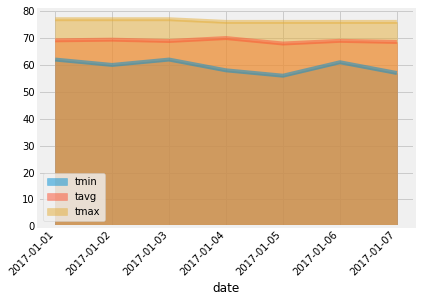

In [53]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normal_pd.plot.area(stacked=False)

x = np.arange(len(date_list))
plt.xticks(x, date_list, rotation=45,horizontalalignment='right')

## Flask App Route Functions

### /api/v1.0/precipitation

In [54]:
#/api/v1.0/precipitation


#Convert the query results to a Dictionary using date as the key and prcp as the value.
#Return the JSON representation of your dictionary.
# @app.route('/api/v1.0/precipitation/')
# def precipitation():

date_prcp_query = session.query(Measurement.date,Measurement.prcp).all()

date_prcp_list =[]
for i in range(len(date_prcp_query)):
    date_prcp_list.append({'date':date_prcp_query[i][0],'precipitation':date_prcp_query[i][1]})

# return jsonify(date_prcp_list)


In [55]:
date_prcp_list

[{'date': '2010-01-01', 'precipitation': 0.08},
 {'date': '2010-01-02', 'precipitation': 0.0},
 {'date': '2010-01-03', 'precipitation': 0.0},
 {'date': '2010-01-04', 'precipitation': 0.0},
 {'date': '2010-01-06', 'precipitation': None},
 {'date': '2010-01-07', 'precipitation': 0.06},
 {'date': '2010-01-08', 'precipitation': 0.0},
 {'date': '2010-01-09', 'precipitation': 0.0},
 {'date': '2010-01-10', 'precipitation': 0.0},
 {'date': '2010-01-11', 'precipitation': 0.01},
 {'date': '2010-01-12', 'precipitation': 0.0},
 {'date': '2010-01-14', 'precipitation': 0.0},
 {'date': '2010-01-15', 'precipitation': 0.0},
 {'date': '2010-01-16', 'precipitation': 0.0},
 {'date': '2010-01-17', 'precipitation': 0.0},
 {'date': '2010-01-18', 'precipitation': 0.0},
 {'date': '2010-01-19', 'precipitation': 0.0},
 {'date': '2010-01-20', 'precipitation': 0.0},
 {'date': '2010-01-21', 'precipitation': 0.0},
 {'date': '2010-01-22', 'precipitation': 0.0},
 {'date': '2010-01-23', 'precipitation': 0.0},
 {'date':

### /api/v1.0/stations

In [56]:
#/api/v1.0/stations
#Return a JSON list of stations from the dataset.
station_query = session.query(Station.station,Station.name).all()


station_list =[]
for i in range(len(station_query)):
    station_list.append({'station':station_query[i][0],'name':station_query[i][1]})
station_list
# return jsonify(station_list)



[{'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US'},
 {'station': 'USC00513117', 'name': 'KANEOHE 838.1, HI US'},
 {'station': 'USC00514830', 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'},
 {'station': 'USC00517948', 'name': 'PEARL CITY, HI US'},
 {'station': 'USC00518838', 'name': 'UPPER WAHIAWA 874.3, HI US'},
 {'station': 'USC00519523', 'name': 'WAIMANALO EXPERIMENTAL FARM, HI US'},
 {'station': 'USC00519281', 'name': 'WAIHEE 837.5, HI US'},
 {'station': 'USC00511918', 'name': 'HONOLULU OBSERVATORY 702.2, HI US'},
 {'station': 'USC00516128', 'name': 'MANOA LYON ARBO 785.2, HI US'}]

### /api/v1.0/tobs

In [57]:
# /api/v1.0/tobs


#query for the dates and temperature observations from a year from the last data point.
#Return a JSON list of Temperature Observations (tobs) for the previous year.

tobs_lastyear_query = session.query(Measurement.date,Station.station,Measurement.tobs).\
                        filter(func.datetime(Measurement.date) >= last_12_month_date).\
                        order_by(Measurement.date).\
                        all()
             

In [58]:
tobs_lastyear_query[0]

('2016-08-23', 'USC00519397', 81.0)

In [59]:
tobs_lastyear_list =[]
for i in range(len(tobs_lastyear_query)):
    tobs_lastyear_list.append({'date':tobs_lastyear_query[i][0],'station':tobs_lastyear_query[i][1],'temperature':tobs_lastyear_query[i][2]})


tobs_lastyear_list
# return jsonify(tobs_lastyear_list)

[{'date': '2016-08-23', 'station': 'USC00519397', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00513117', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00514830', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00517948', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00518838', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00519523', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00519281', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00511918', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00516128', 'temperature': 81.0},
 {'date': '2016-08-23', 'station': 'USC00519397', 'temperature': 76.0},
 {'date': '2016-08-23', 'station': 'USC00513117', 'temperature': 76.0},
 {'date': '2016-08-23', 'station': 'USC00514830', 'temperature': 76.0},
 {'date': '2016-08-23', 'station': 'USC00517948', 'temperature': 76.0},
 {'date': '2016-08-23', 'station': 'USC00518838', 'temperature':

### /api/v1.0/ start and /api/v1.0/start/end

In [60]:
#/api/v1.0/<start> and /api/v1.0/<start>/<end>


#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
#When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

start='2017-01-01'
end='2017-02-15'

last_date='2017-08-23'




In [61]:
def duration_temperature(start_date,end_date):
    start_date_list = start_date.split('-')
    end_date_list = end_date.split('-')

    start_day_type = date(int(start_date_list[0]),int(start_date_list[1]),int(start_date_list[2]))
    end_day_type = date(int(end_date_list[0]),int(end_date_list[1]),int(end_date_list[2]))
    delta = end_day_type - start_day_type
    day_duration = delta.days


    next_day_list =[]
    date_list =[]

    for i in range(day_duration+1):
        next_day_type = start_day_type + timedelta(days=i)
        day_str = next_day_type.strftime('%Y-%m-%d')
        next_day_list.append(day_str[5:])
        date_list.append(day_str)

    daily_normal_temp=[]
    for i in range(len(next_day_list)):
        daily_normal_temp.append(daily_normals(next_day_list[i])[0])
    
    # Build final dict list for jsonify
    dur_temp_list=[]
    for i in range(len(daily_normal_temp)):
        dur_temp_list.append({'date':date_list[i],\
                              'min temp':daily_normal_temp[i][0],\
                              'avg temp':daily_normal_temp[i][1],\
                              'max temp':daily_normal_temp[i][1]})
        
    return dur_temp_list

In [62]:
start_list = duration_temperature(start,last_date)
# return jsonify(start_list)

In [63]:
start_list

[{'date': '2017-01-01',
  'min temp': 62.0,
  'avg temp': 69.15384615384616,
  'max temp': 69.15384615384616},
 {'date': '2017-01-02',
  'min temp': 60.0,
  'avg temp': 69.39622641509433,
  'max temp': 69.39622641509433},
 {'date': '2017-01-03',
  'min temp': 62.0,
  'avg temp': 68.9090909090909,
  'max temp': 68.9090909090909},
 {'date': '2017-01-04', 'min temp': 58.0, 'avg temp': 70.0, 'max temp': 70.0},
 {'date': '2017-01-05',
  'min temp': 56.0,
  'avg temp': 67.96428571428571,
  'max temp': 67.96428571428571},
 {'date': '2017-01-06',
  'min temp': 61.0,
  'avg temp': 68.96491228070175,
  'max temp': 68.96491228070175},
 {'date': '2017-01-07',
  'min temp': 57.0,
  'avg temp': 68.54385964912281,
  'max temp': 68.54385964912281},
 {'date': '2017-01-08',
  'min temp': 57.0,
  'avg temp': 67.16071428571429,
  'max temp': 67.16071428571429},
 {'date': '2017-01-09',
  'min temp': 58.0,
  'avg temp': 67.9298245614035,
  'max temp': 67.9298245614035},
 {'date': '2017-01-10',
  'min temp':

In [64]:
start_end_list = duration_temperature(start,end)
#return jsonify(start_end_list)

In [65]:
start_end_list

[{'date': '2017-01-01',
  'min temp': 62.0,
  'avg temp': 69.15384615384616,
  'max temp': 69.15384615384616},
 {'date': '2017-01-02',
  'min temp': 60.0,
  'avg temp': 69.39622641509433,
  'max temp': 69.39622641509433},
 {'date': '2017-01-03',
  'min temp': 62.0,
  'avg temp': 68.9090909090909,
  'max temp': 68.9090909090909},
 {'date': '2017-01-04', 'min temp': 58.0, 'avg temp': 70.0, 'max temp': 70.0},
 {'date': '2017-01-05',
  'min temp': 56.0,
  'avg temp': 67.96428571428571,
  'max temp': 67.96428571428571},
 {'date': '2017-01-06',
  'min temp': 61.0,
  'avg temp': 68.96491228070175,
  'max temp': 68.96491228070175},
 {'date': '2017-01-07',
  'min temp': 57.0,
  'avg temp': 68.54385964912281,
  'max temp': 68.54385964912281},
 {'date': '2017-01-08',
  'min temp': 57.0,
  'avg temp': 67.16071428571429,
  'max temp': 67.16071428571429},
 {'date': '2017-01-09',
  'min temp': 58.0,
  'avg temp': 67.9298245614035,
  'max temp': 67.9298245614035},
 {'date': '2017-01-10',
  'min temp':